## ATTENTION, SI VOUS LANCEZ TOUT VOUS ECRASEZ LES RESULTATS EXISTANTS ET CA PREND 4H À TOUT COMPILER. 

In [ ]:
#Fonctions personnalisées
from DataManager import DataManager
from models import ss_kf_fit, run_nnar_pipeline, run_garch_pipeline
from stats import *
from plotting import *

#Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd 
import scipy.stats as stats
import numpy as np 

from scipy.stats import norm, t
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import time
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="ValueWarning: A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", message="ConvergenceWarning: Maximum Likelihood optimization failed to converge.")
warnings.filterwarnings("ignore", message="ConvergenceWarning: The optimizer returned code 4")
import os
os.chdir('..')
print(os.getcwd())

c:\Users\julie\Downloads\Programmation\Python\Projet Gestion Quant


## REPRODUCTION DES RESULTATS DU PAPIER

## IMPORTATION DES DONNEES

In [2]:
# Définition des chemins vers les fichiers
crypto_paths = {
    "BTC": r"Data\Data papier\BTC.csv",
}

# Initialisation des Data Managers
managers = {name: DataManager(csv_path=path) for name, path in crypto_paths.items()}

# Chargement et nettoyage des données
for manager in managers.values():
    manager.load_and_clean_data(date_col='date', price_col='close',rows_to_skip=0, dayfirst=True)
    manager.split_pre_and_post_covid()

# Récupération des données pour vérification
data = {name: manager.get_data_timeperiod(subset='covid') for name, manager in managers.items()}

# Récupération des rendements log pour la période COVID
returns = {name: managers[name].get_log_returns(data[name]) for name in data}

#Récupération des rends centrés réduits pour la période COVID
centred_returns = {name: managers[name].get_centred_log_returns(data[name]) for name in data}

# Calcul de la volatilité observée
observed_vols = {name: observed_volatility(returns[name]) for name in returns}



## PLOT LOG RETURNS DES TOKENS 

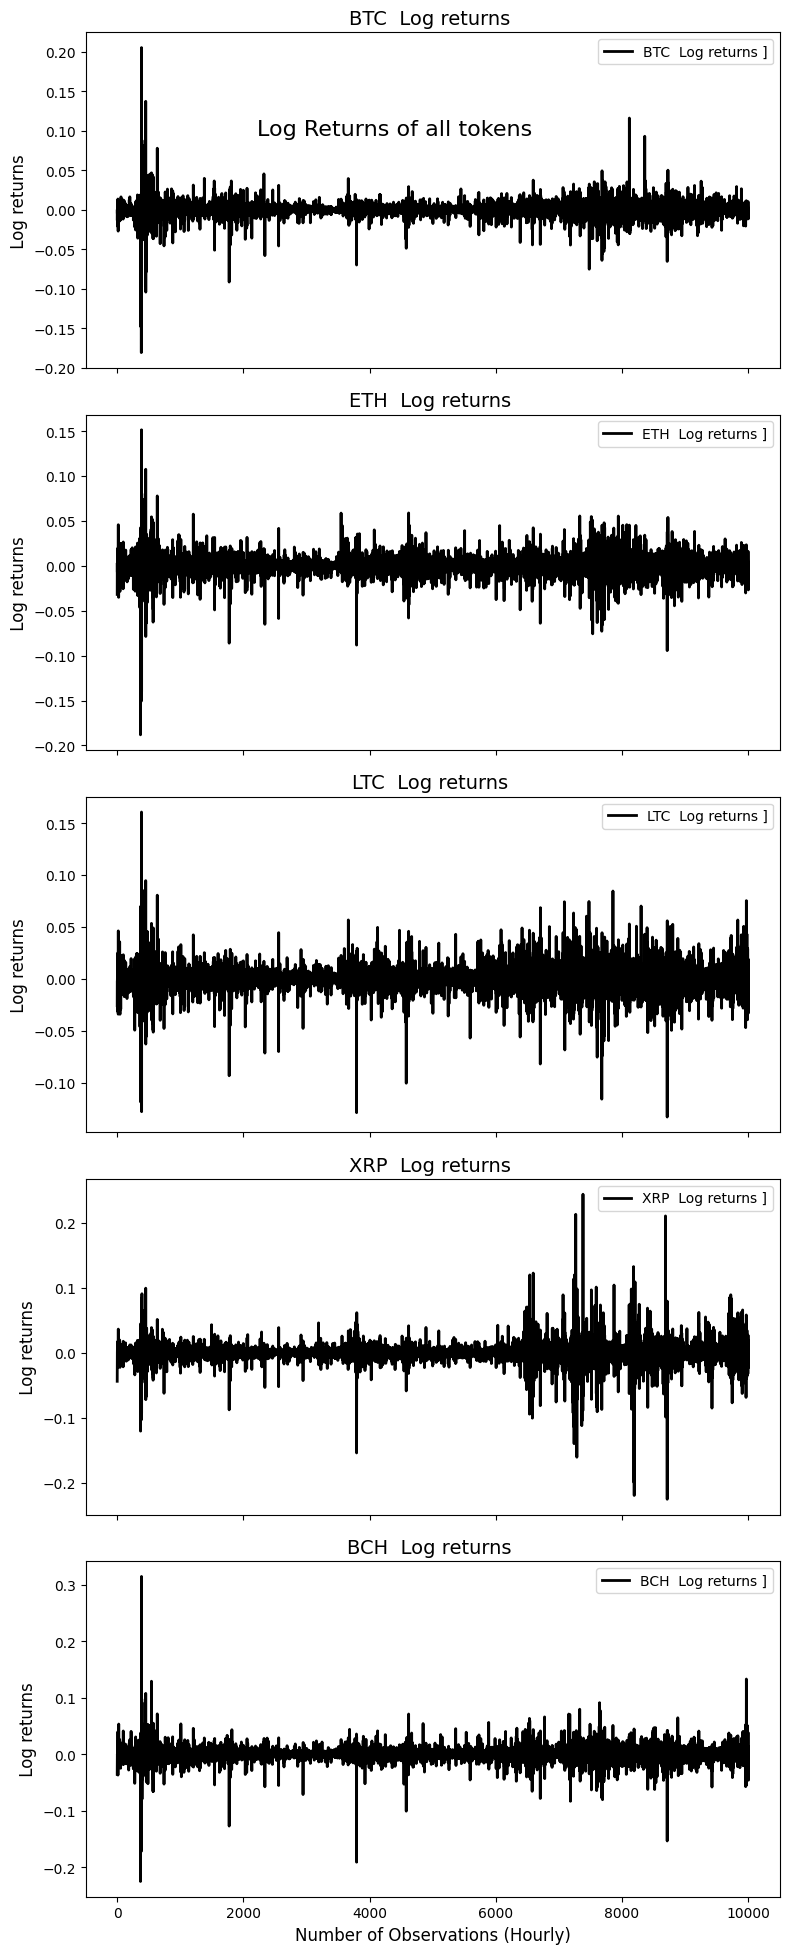

In [3]:
# Exemple d'utilisation
title = "Log Returns of all tokens"
subject =" Log returns "
plot_observed_vols(returns,title,subject)

## PLOT VOLATILITE OBSERVEE DES TOKENS 

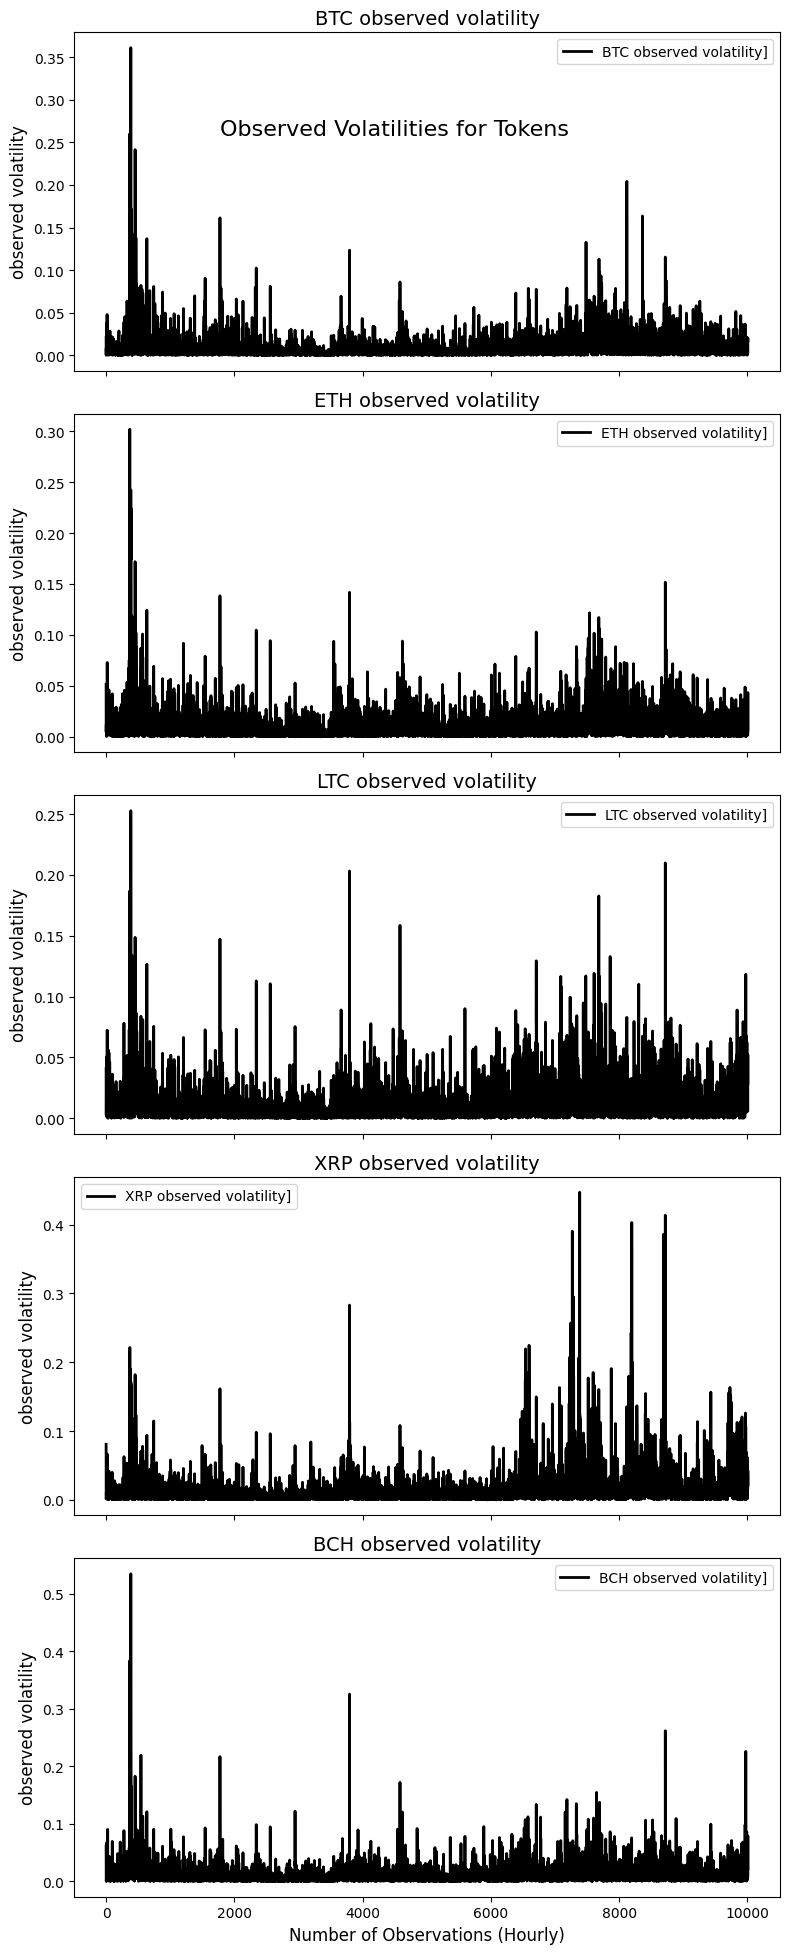

In [4]:
# Exemple d'utilisation
title = "Vol of all tokens"
subject =" Observed Volatility"
plot_observed_vols(observed_vols)

## FIT DE TOUS LES MODELES 

## Fit d'un modèle pour démo

In [7]:
results = {}

print("On commence à fit le GARCH")
time_start = time.time()

# Exécution du pipeline GARCH
garch_res = run_garch_pipeline(
    y_returns=returns["BTC"],
    y_obs_vol=observed_vols["BTC"],
    horizon=1
)
time_end = time.time()
print(f"Temps d'exécution du GARCH : {time_end - time_start} secondes")

print("On commence à fit le NNAR")
time_start = time.time()

# Exécution du pipeline NNAR
nnar_res = run_nnar_pipeline(
    y_obs_vol=observed_vols["BTC"],
    p_range=(1,40), k_range=(1,40), activation='logistic', max_iter=1000,
    horizon=1
)
time_end = time.time()
print(f"Temps d'exécution du NNAR : {time_end - time_start} secondes")

print("On commence à fit le SS ARIMA")
time_start = time.time()

ss_ARIMA_res = ss_kf_fit(returns["BTC"], observed_vols["BTC"])

time_end = time.time()
print(f"Temps d'exécution du SS ARIMA : {time_end - time_start} secondes")


# Stocker tout dans results
results["BTC"] = {
    'GARCH': garch_res,
    'NNAR': nnar_res,
    "SS ARIMA" : ss_ARIMA_res    
}


## Représentation graphique des fits 

BTC


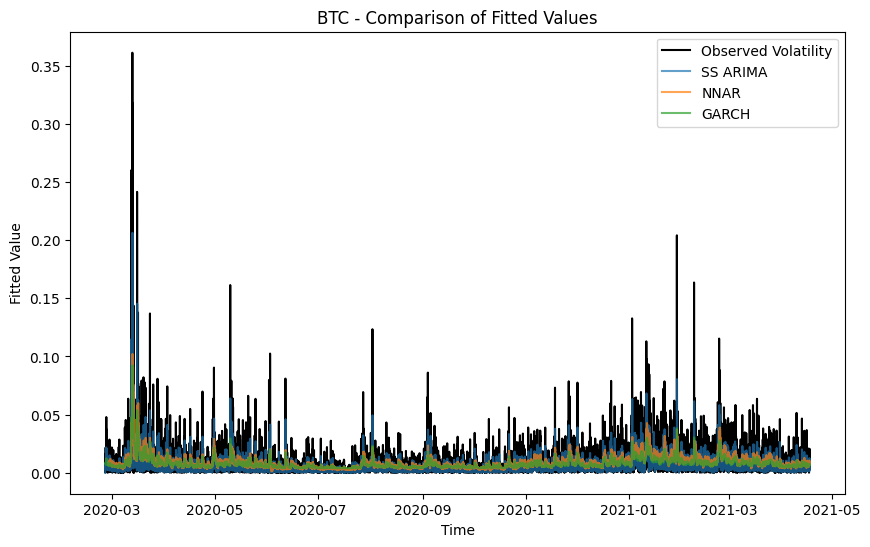

ETH


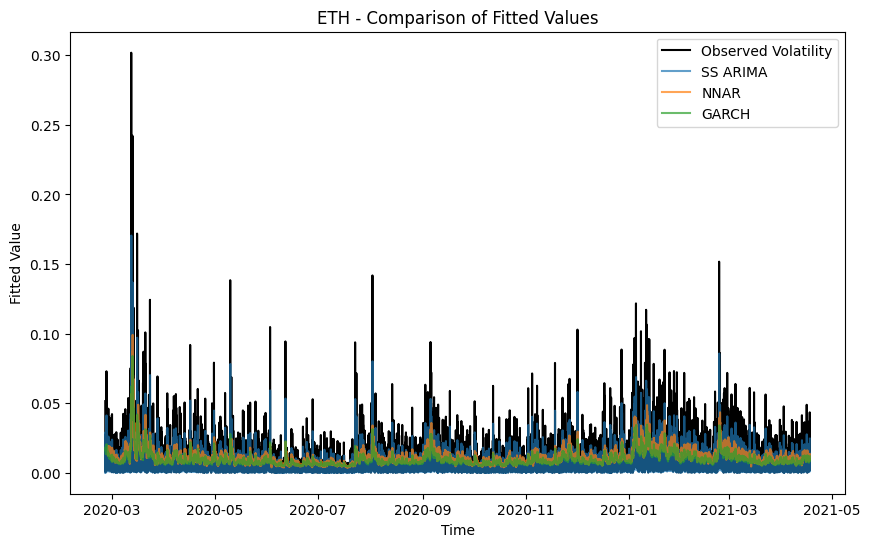

LTC


XRP


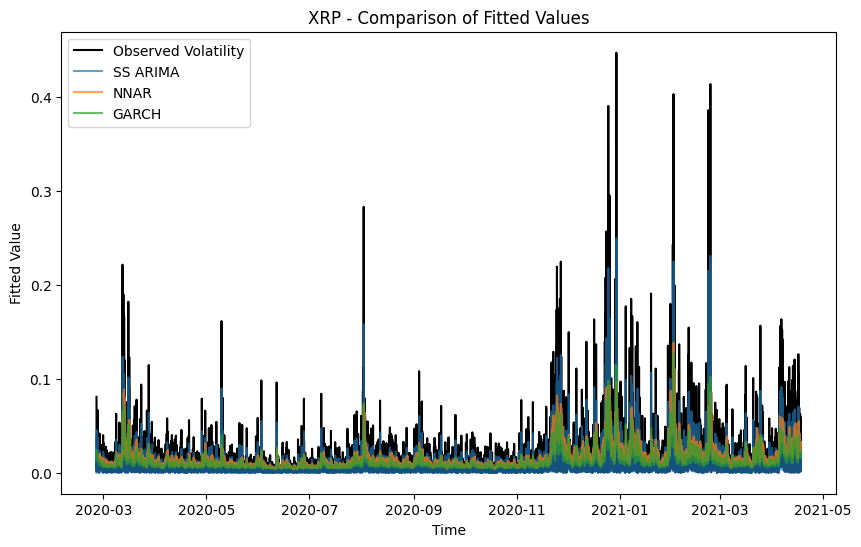

BCH


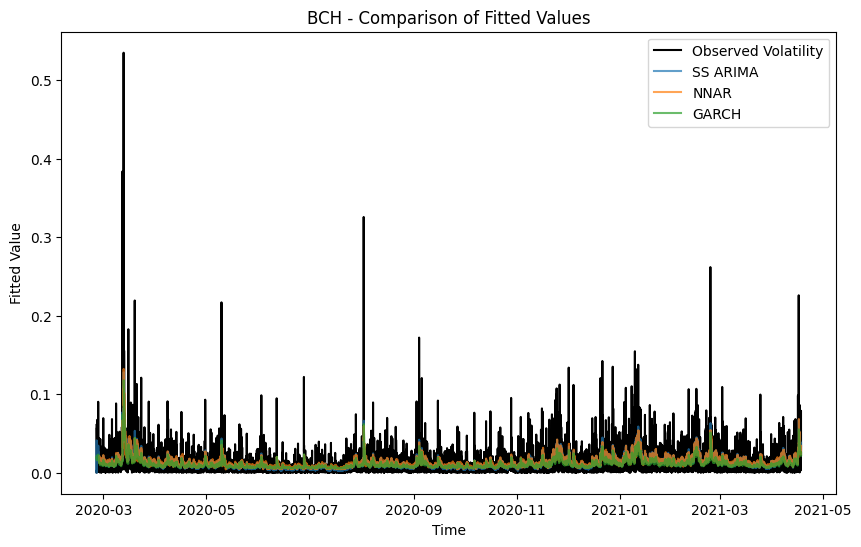

In [8]:
models = ["SS ARIMA","NNAR", "GARCH"]

for crypto in results:
    print(crypto)
    plt.figure(figsize=(10, 6))
    plt.title(f"{crypto} - Comparison of Fitted Values")

    plt.plot(observed_vols[crypto], label="Observed Volatility", color='black')
    for model in models: #Je veux itérer dans un ordre précis donc je ne peux pas utiliser results[crypto]
        fitted = results[crypto][model]['Fitted_values']

        if hasattr(fitted, 'dropna'):
            fitted = fitted.dropna()

        plt.plot(fitted, label=model, alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Fitted Value")
    plt.legend()
    plt.show()

## STATS DESCRIPTIVES

In [9]:
descriptive_stats = {}

for name in results:
    current_returns = returns[name]

    nnar_params  = results[name]['NNAR']['NNAR_order']
    arima_params = results[name]['SS ARIMA']['ARIMA_order']

    stats_dict = descriptive_statistics(
        current_returns, arima_params, nnar_params
    )
    descriptive_stats[name] = stats_dict

data_desc = pd.DataFrame.from_dict(descriptive_stats, orient='index')

data_desc


Maximum   Minimum      Mean    Median       Std  Skewness   Kurtosis  \
BTC  0.205483 -0.180903  0.000185  0.000184  0.009231 -0.219181  68.146001   
ETH  0.151434 -0.188197  0.000223  0.000253  0.010848 -0.858119  27.811180   
LTC  0.160655 -0.133141  0.000144  0.000162  0.012086 -0.337926  16.025828   
XRP  0.243802 -0.225254  0.000180  0.000000  0.015440 -0.069044  37.000218   
BCH  0.314574 -0.225550  0.000102  0.000126  0.012784  0.125635  67.644952   

    ARIMA params NNAR params  
BTC    (2, 0, 0)    (38, 28)  
ETH    (1, 0, 0)    (36, 38)  
LTC    (2, 0, 0)    (34, 35)  
XRP    (1, 0, 0)    (38, 39)  
BCH    (3, 0, 2)    (36, 38)

## TABLEAU MAE & RMSE 

In [10]:
mae_rmse_results = {
    crypto: {
        "GARCH": {},
        "NNAR": {},
        "SS ARIMA": {}
    } 
    for crypto in results
}

for name in results:
    for model in mae_rmse_results[name]:
        mae_rmse_results[name][model]["MAE"] = results[name][model]['MAE']
        mae_rmse_results[name][model]["RMSE"] = results[name][model]['RMSE']
        
rows = []
for crypto, models_dict in mae_rmse_results.items():
    for model, metrics in models_dict.items():
        rows.append({
            "Model": model,
            "Crypto": crypto,
            "MAE": metrics["MAE"],
            "RMSE": metrics["RMSE"]
        })

df_stat_desc = pd.DataFrame(rows)

df_stat_desc = df_stat_desc.pivot(index="Model", columns="Crypto", values=["MAE", "RMSE"])
df_stat_desc = df_stat_desc.swaplevel(axis=1)  # échange le niveau 0 et niveau 1 des colonnes
df_stat_desc = df_stat_desc.sort_index(axis=1, level=0)  # trie les colonnes par la crypto

# On applique la fonction pour mettre en gras à chaque colonne RMSE/MAE :
columns_to_style = df_stat_desc.columns  
df_stat_desc = df_stat_desc.style.apply(highlight_min_in_col, subset=columns_to_style)

df_stat_desc



## Etude des résidus

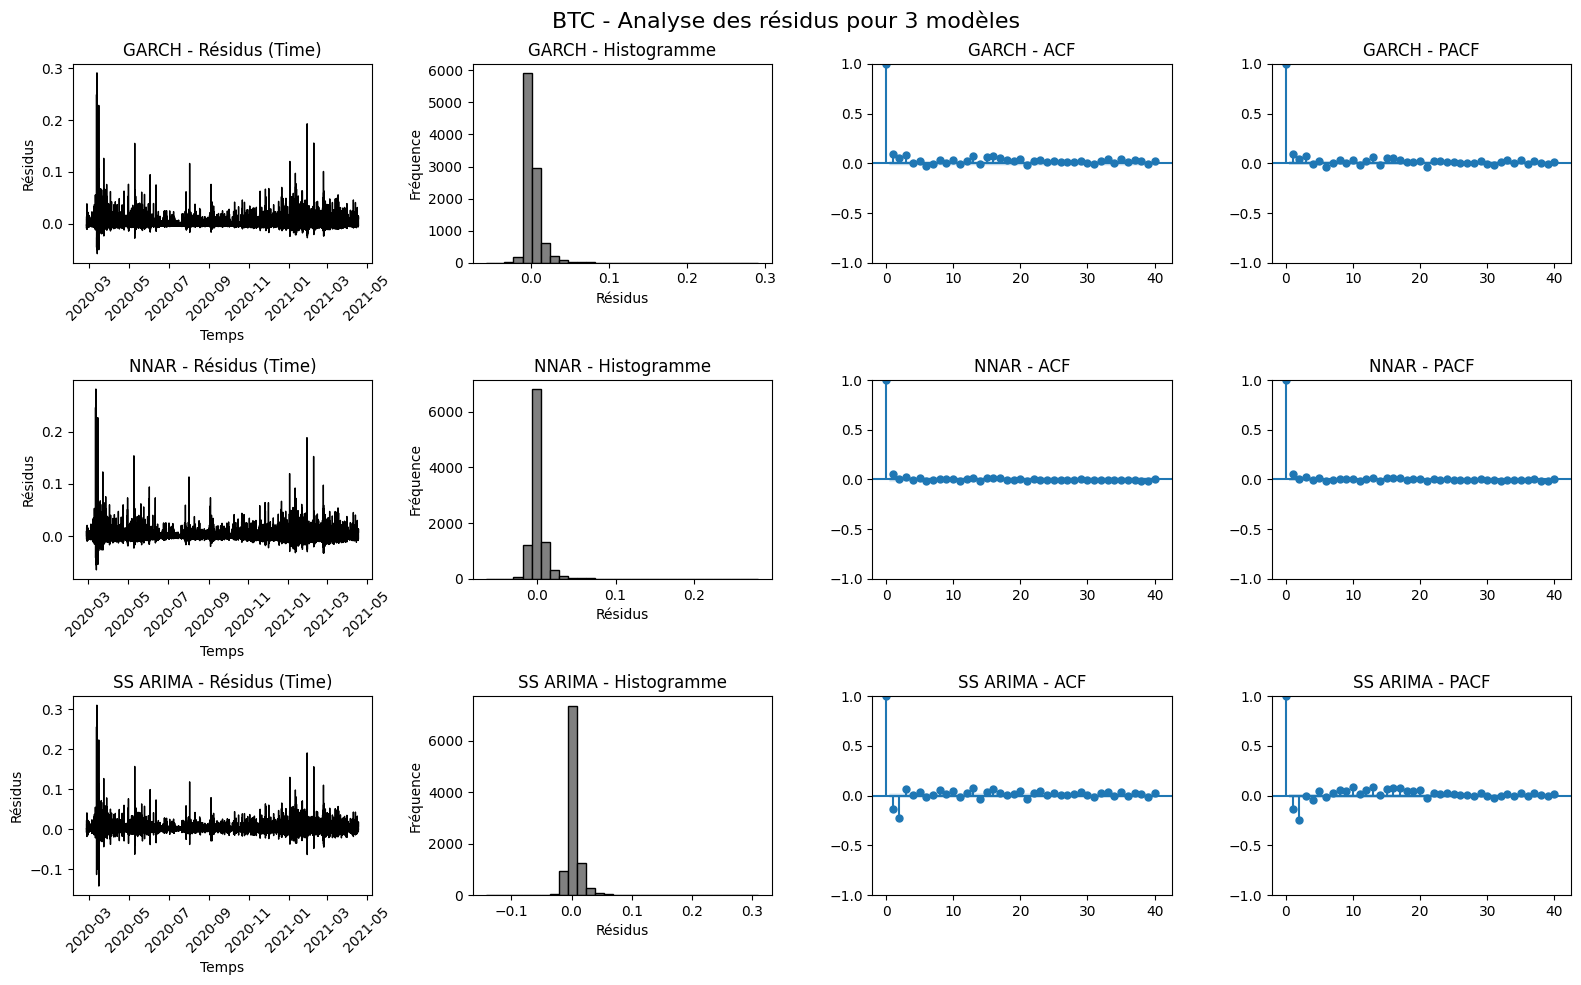

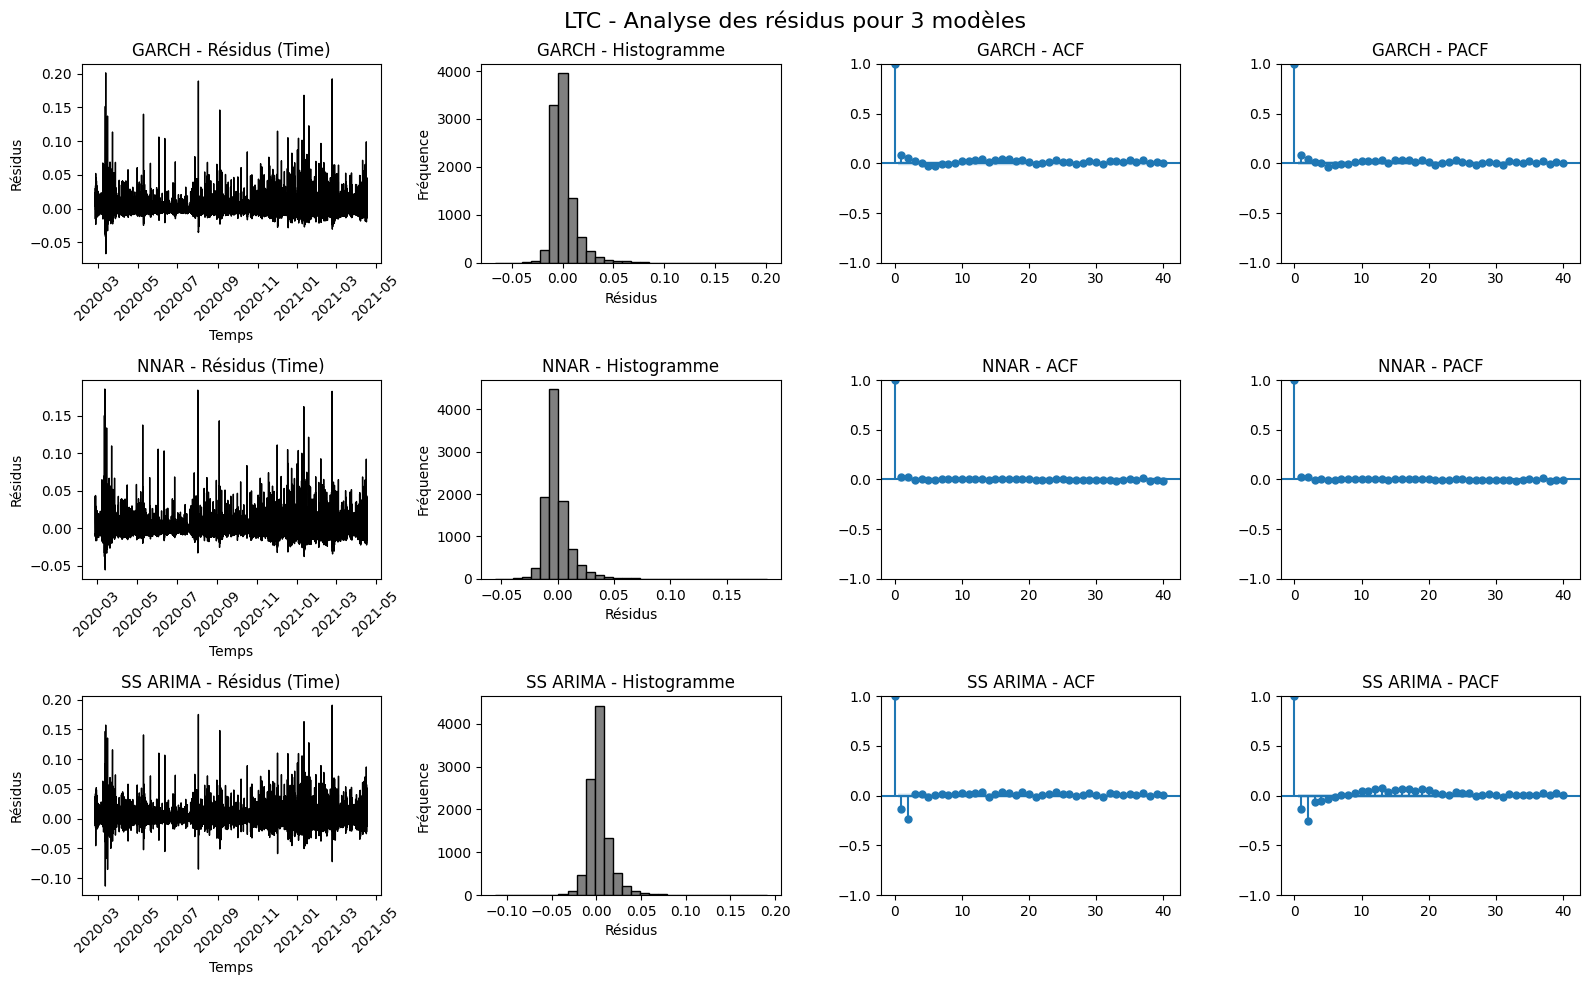

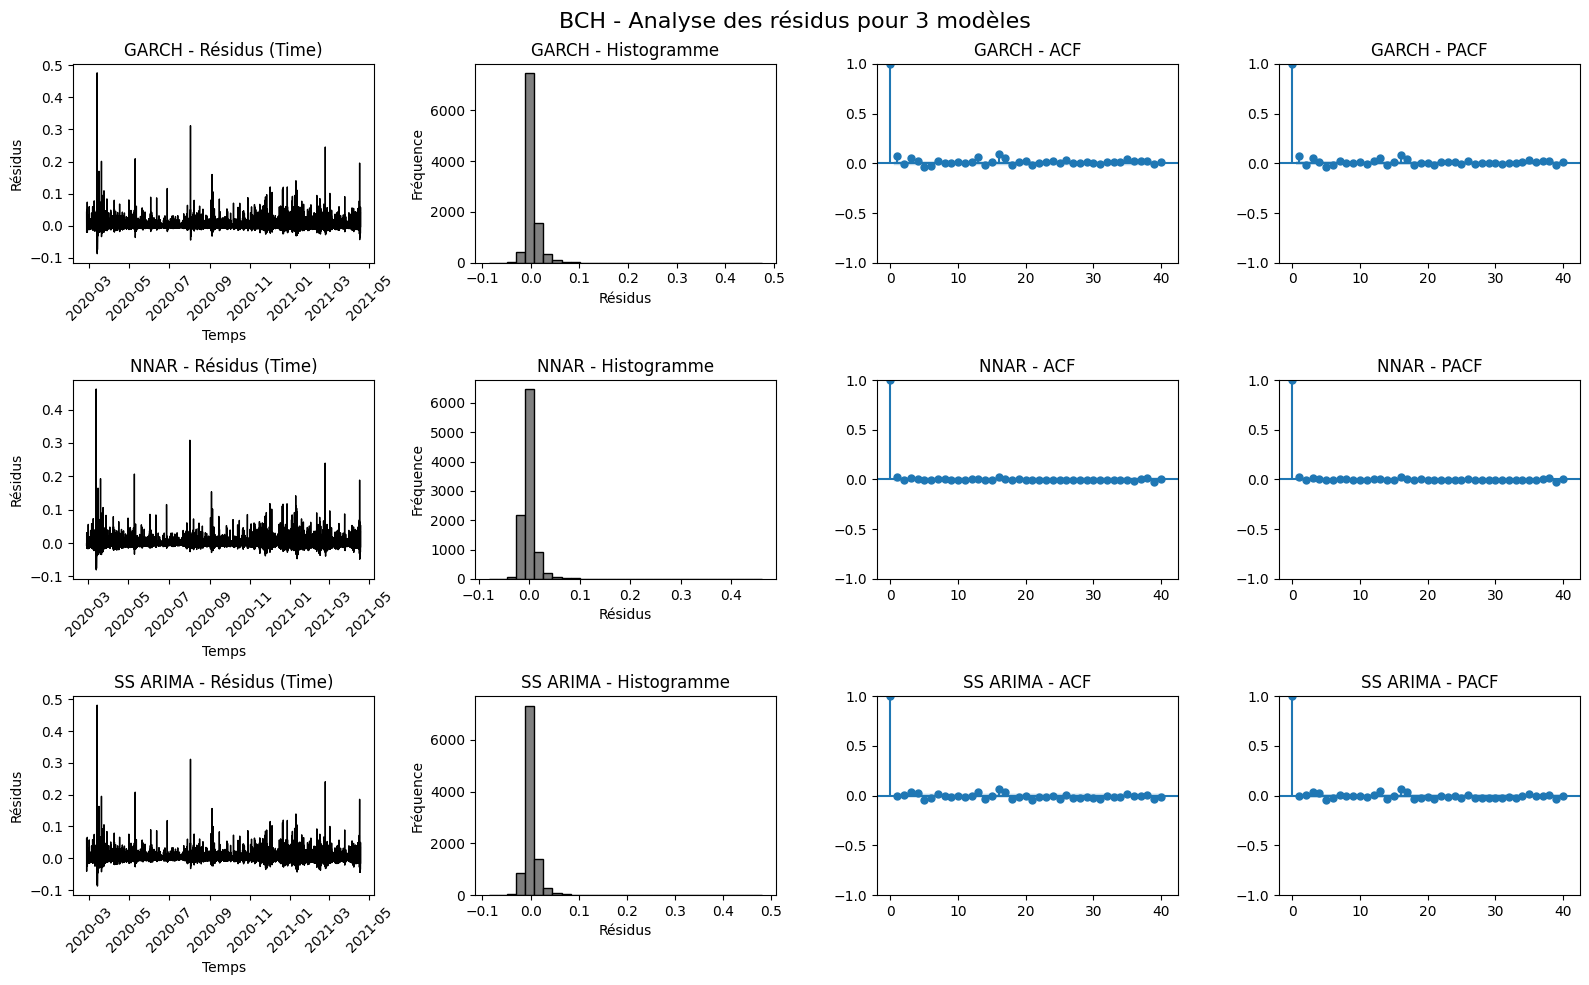

In [11]:
models_order = ["GARCH", "NNAR", "SS ARIMA"]  # L'ordre que je veux représenter

residuals = {crypto: {"GARCH": None, "NNAR": None, "SS ARIMA": None} for crypto in results}

for name in results:
    for model in residuals[name]:
        residuals[name][model] = results[name][model]['Residuals']

for crypto in residuals:

    # Crée une figure 3x4 : 3 lignes (pour 3 modèles), 4 colonnes (time series, hist, ACF, PACF)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
    fig.suptitle(f"{crypto} - Analyse des résidus pour 3 modèles", fontsize=16)

    for i, model in enumerate(models_order):
        res = residuals[crypto][model]
    
        if hasattr(res, "dropna"):
            res = res.dropna()
        else:
            res = res[~np.isnan(res)]

        #Plot Time Series 
        axes[i, 0].plot(res, color='black', linewidth=1)
        axes[i, 0].set_title(f"{model} - Résidus (Time)")
        axes[i, 0].set_xlabel("Temps")
        axes[i, 0].set_ylabel("Résidus")
        
        # Configuration des ticks de l'axe des x
        axes[i, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
        axes[i, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        axes[i, 0].tick_params(axis='x', rotation=45) 

        # Histogram
        axes[i, 1].hist(res, bins=30, color='gray', edgecolor='black')
        axes[i, 1].set_title(f"{model} - Histogramme")
        axes[i, 1].set_xlabel("Résidus")
        axes[i, 1].set_ylabel("Fréquence")

        # ACF
        plot_acf(res, ax=axes[i, 2], lags=40, alpha=0.05)
        axes[i, 2].set_title(f"{model} - ACF")
        # PACF
        plot_pacf(res, ax=axes[i, 3], lags=40, alpha=0.05, method='ywm')
        axes[i, 3].set_title(f"{model} - PACF")

    plt.tight_layout()
    plt.show()

## Etude de Volatilité

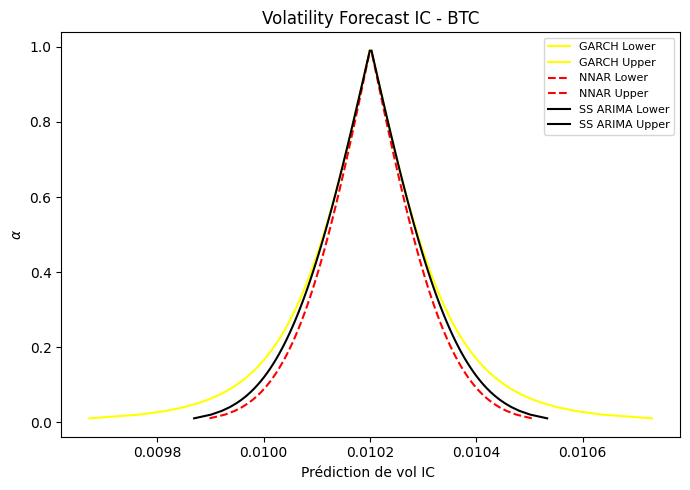

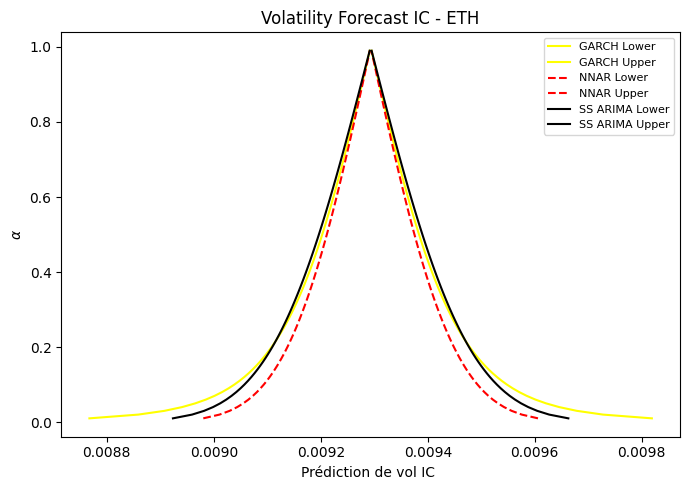

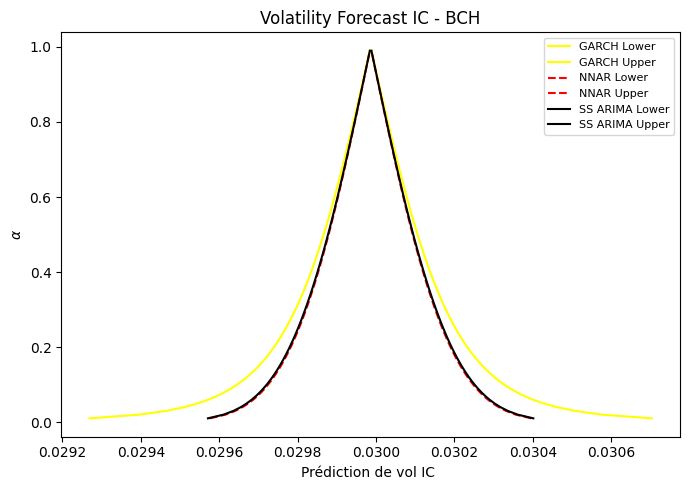

In [12]:
alpha_array = np.arange(0.01, 1.00, 0.01)

all_vol_ci = {}
for name in results:
    vol_ci = compute_volatility_ci(results[name], alpha_array)
    plot_IC(vol_ci, title=f"Volatility Forecast IC - {name}")
    all_vol_ci[name] = vol_ci


## Représentation de l'IC de la VaR 

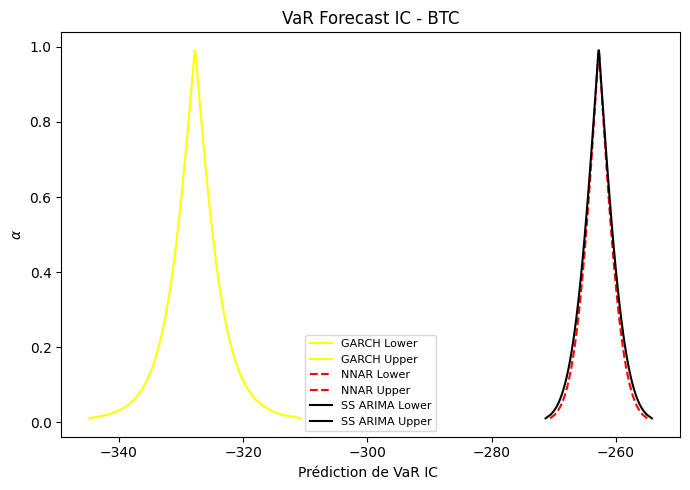

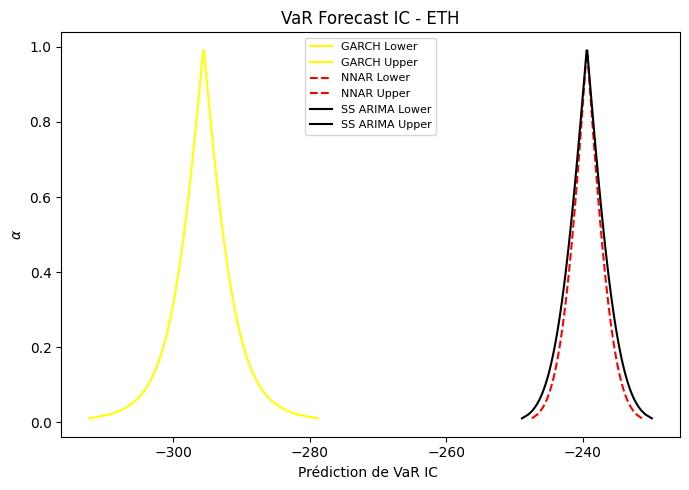

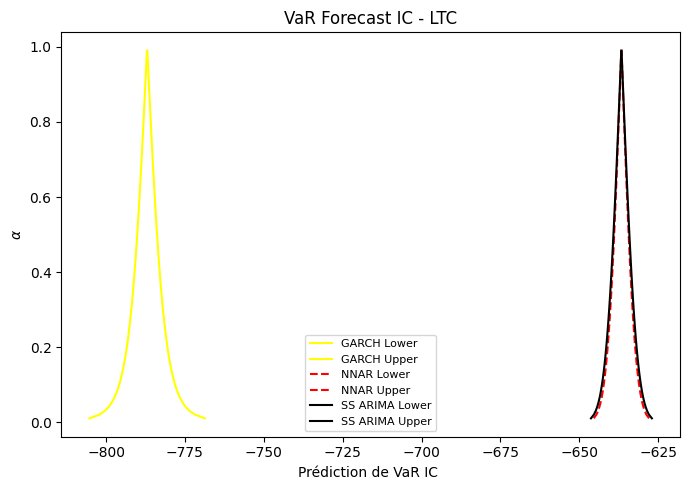

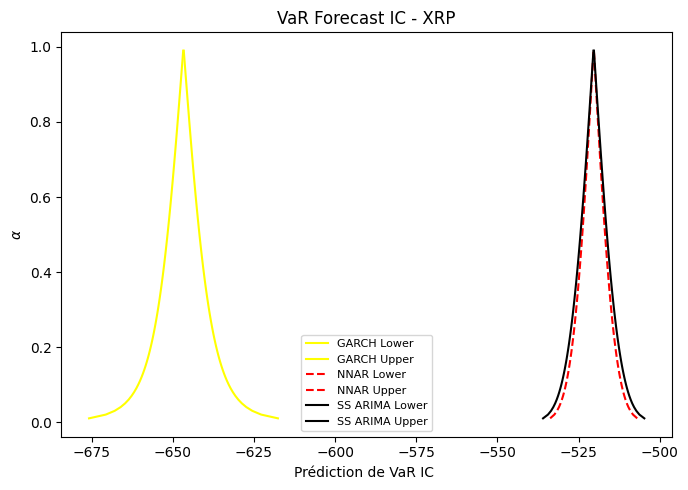

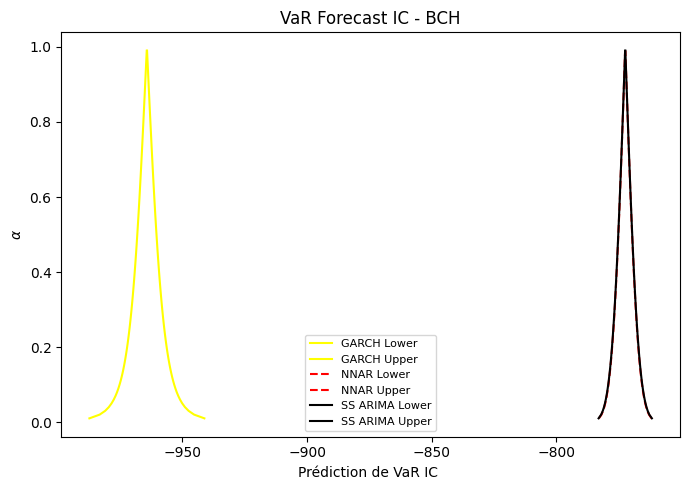

In [13]:
#Version statistiquement correcte
for name in results: 
    vol_ci = all_vol_ci[name]
    
    var_ci = compute_var_ci(vol_ci, alpha_array, results[name], alpha_var=0.01, nominal=10_000)
    plot_IC(var_ci, title=f"VaR Forecast IC - {name}", type="VaR")

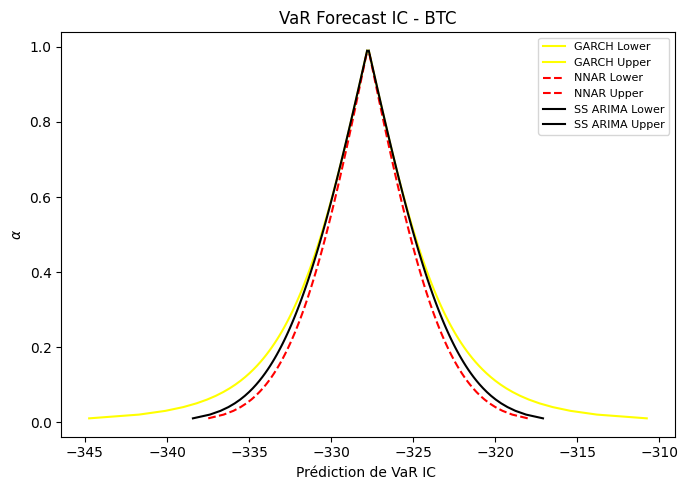

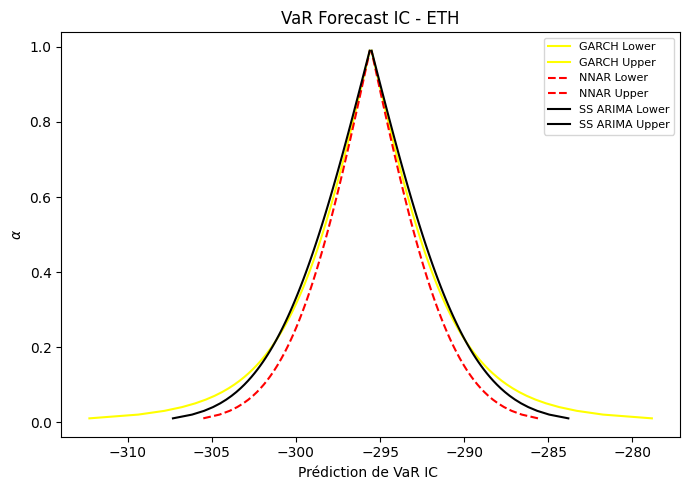

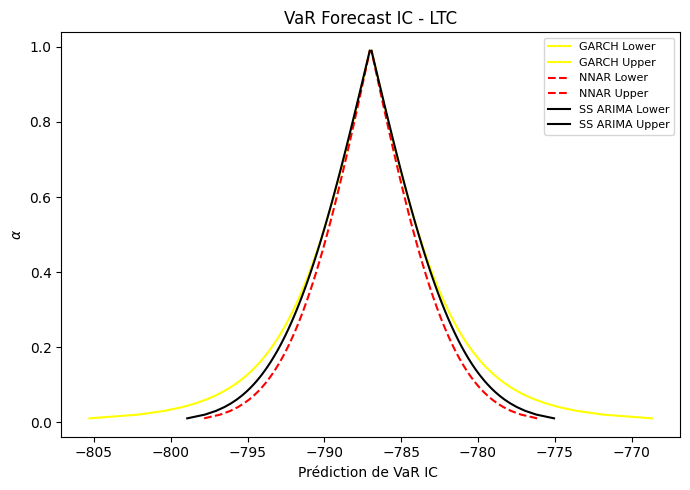

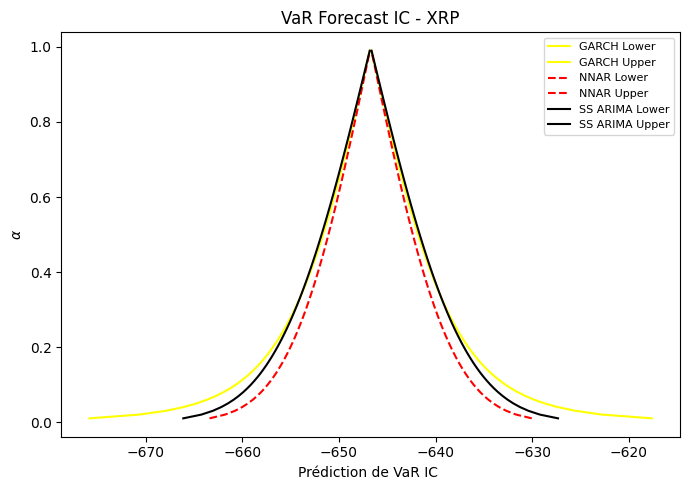

In [20]:
#Version du papier
for name in results: 
    vol_ci = all_vol_ci[name]
    
    var_ci = compute_var_ci_df(vol_ci, alpha_array, results[name], alpha_var=0.01, nominal=10_000)
    plot_IC(var_ci, title=f"VaR Forecast IC - {name}", type="VaR")

# REPRODUCTION AVEC UNE NOUVELLE VOL

## IMPORTATION DES DONNÉES 

In [1]:
# Définition des chemins vers les fichiers 1 min pour calculer la vol 
crypto_paths_1min = {
    "BTC": r"Data\Data 1 min\BTC_USDT_binance_1m_2020-02-24_2021-04-30.csv",
}

managers_1min = {name: DataManager(csv_path=path) for name, path in crypto_paths_1min.items()}

# Chargement et nettoyage des données
for manager in managers_1min.values():
    manager.load_and_clean_data(date_col='timestamp', price_col='close',rows_to_skip=0)
    manager.split_pre_and_post_covid()


# Récupération des données pour vérification
data_1min = {name: manager.get_data_timeperiod(subset='covid') for name, manager in managers_1min.items()}

returns_1_min = {name: managers_1min[name].get_log_returns_from_min_freq(data_1min[name]) for name in data_1min}
observed_vols_1_min = {name: obs_vol_by_mins(data_1min[name]) for name in data_1min}
centred_returns_1_min = {name: managers_1min[name].get_centred_log_returns_from_min_freq(data_1min[name]) for name in data_1min}  

for name in data_1min:  #Etape supplémentaire pour gérer les timestemp manquants (très peu 5h en moyenne sur 10000h de datas)
    missing_in_returns = set(observed_vols_1_min[name].index) - set(returns_1_min[name].index)
    observed_vols_1_min[name] = observed_vols_1_min[name].loc[observed_vols_1_min[name].index.difference(missing_in_returns)]

NameError: name 'DataManager' is not defined

## PLOT LOG RETURNS CENTRÉS DES TOKENS 

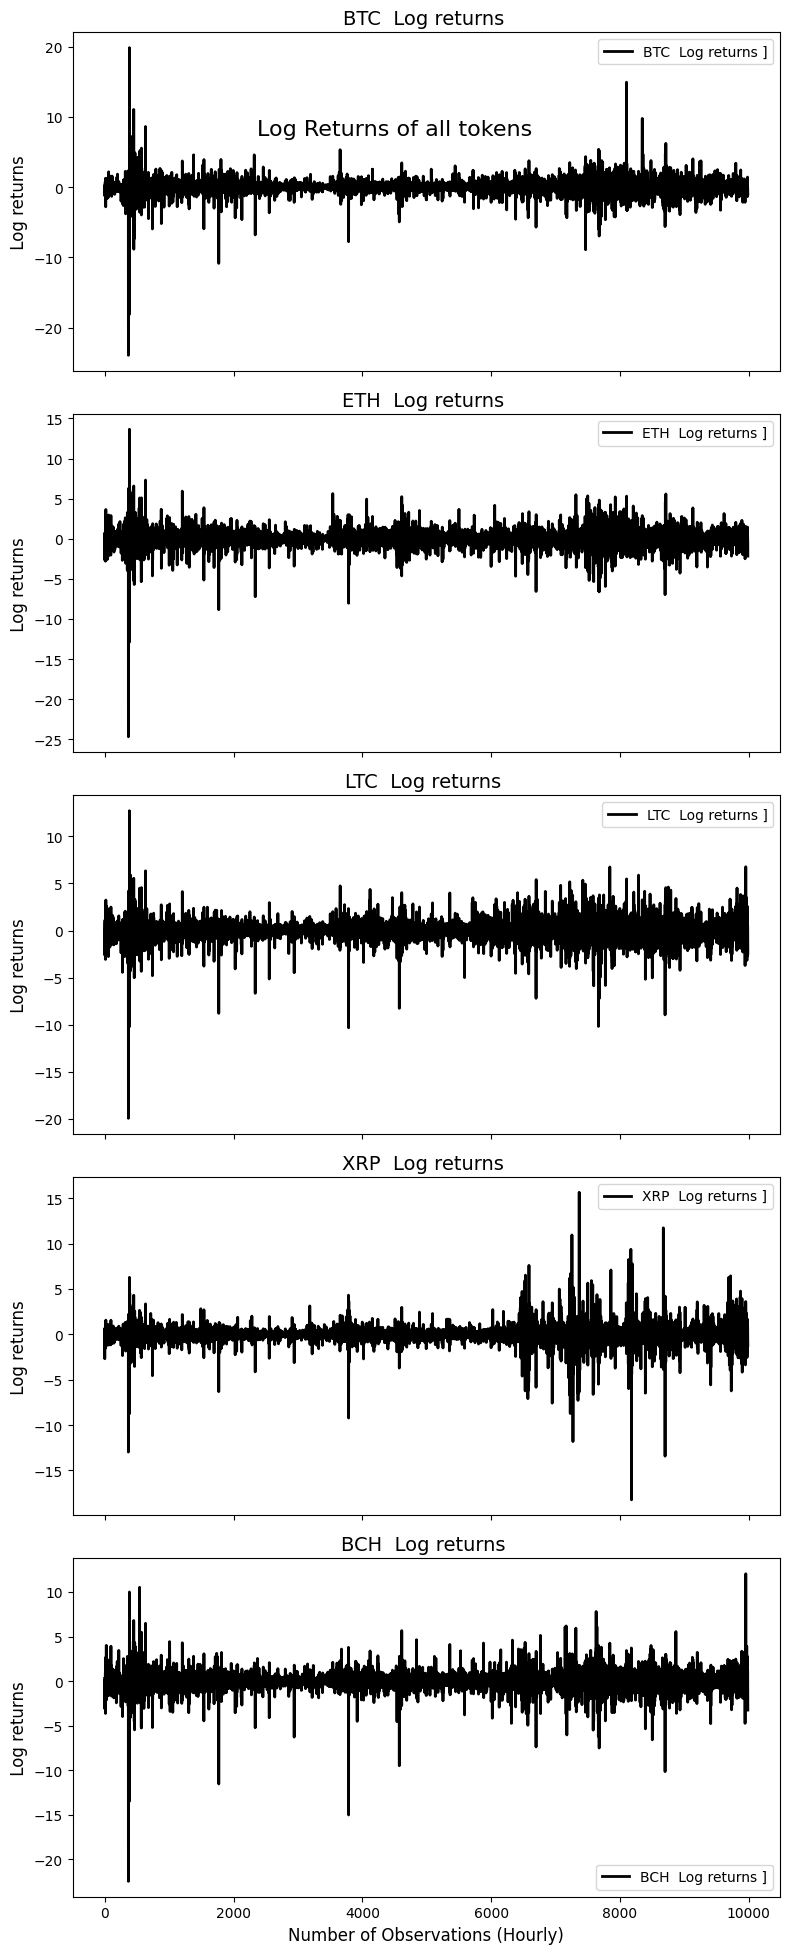

In [16]:
title = "Log Returns of all tokens"
subject =" Log returns "
plot_observed_vols(centred_returns_1_min,title,subject)

## PLOT VOLATILITÉ OBSERVÉE DES TOKENS 

In [17]:
title = "Vol of all tokens"
subject =" Observed Volatility"
plot_observed_vols(observed_vols_1_min)

## FIT DE TOUS LES MODELES POUR UN TOKEN 

In [ ]:
results_1_min = {}

print("On commence à fit le GARCH")
time_start = time.time()

# Exécution du pipeline GARCH
garch_res_1_min = run_garch_pipeline(
    y_returns=returns_1_min["BTC"],
    y_obs_vol=observed_vols_1_min["BTC"],
    horizon=1
)
time_end = time.time()
print(f"Temps d'exécution du GARCH : {time_end - time_start} secondes")

print("On commence à fit le NNAR")
time_start = time.time()

# Exécution du pipeline NNAR
nnar_res_1_min = run_nnar_pipeline(
    y_obs_vol=observed_vols_1_min["BTC"],
    p_range=(1,40), k_range=(1,40), activation='logistic', max_iter=1000,
    horizon=1
)
time_end = time.time()
print(f"Temps d'exécution du NNAR : {time_end - time_start} secondes")

print("On commence à fit le SS ARIMA")
time_start = time.time()

ss_ARIMA_res_1_min = ss_kf_fit(returns_1_min["BTC"], observed_vols_1_min["BTC"])

time_end = time.time()
print(f"Temps d'exécution du SS ARIMA : {time_end - time_start} secondes")


# Stocker tout dans results
results_1_min["BTC"] = {
    'GARCH': garch_res_1_min,
    'NNAR': nnar_res_1_min,
    "SS ARIMA" : ss_ARIMA_res_1_min   
}

## REPRÉSENTATION DES FITS 

BTC


ETH


LTC


XRP


BCH


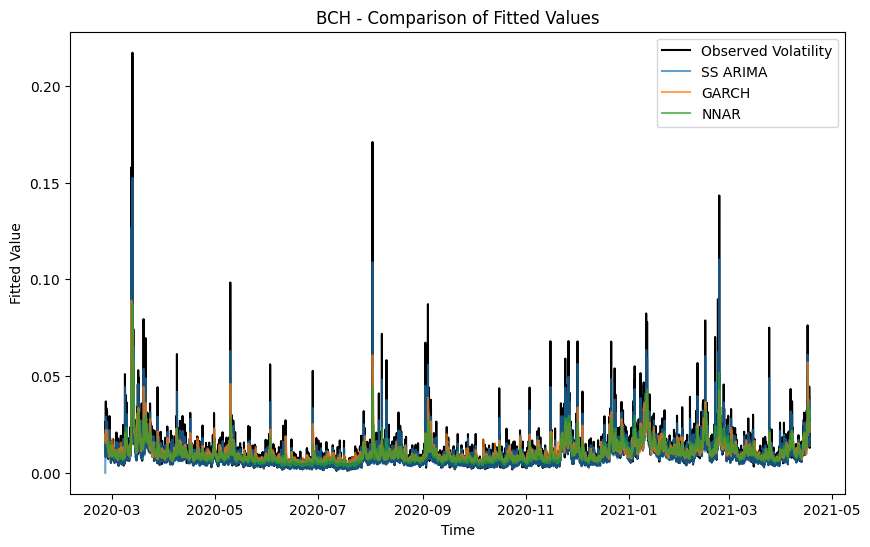

In [22]:
models = ["SS ARIMA", "GARCH", "NNAR"]

for crypto in results_1_min:
    print(crypto)
    plt.figure(figsize=(10, 6))
    # Titre
    plt.title(f"{crypto} - Comparison of Fitted Values")

    plt.plot(observed_vols_1_min[crypto], label="Observed Volatility", color='black')
    for model in models: #Je veux itérer dans un ordre précis donc je ne peux pas utiliser results_1_min[crypto]
        fitted = results_1_min[crypto][model]['Fitted_values']

        if hasattr(fitted, 'dropna'):
            fitted = fitted.dropna()

        plt.plot(fitted, label=model, alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Fitted Value")
    plt.legend()
    plt.show()

## TABLEAU RMSE & MAE 

In [23]:
mae_rmse_results_1_min = {
    crypto: {
        "GARCH": {},
        "NNAR": {},
        "SS ARIMA": {}
    } 
    for crypto in results
}

for name in results_1_min:
    for model in mae_rmse_results_1_min[name]:
        mae_rmse_results_1_min[name][model]["MAE"] = results[name][model]['MAE']
        mae_rmse_results_1_min[name][model]["RMSE"] = results[name][model]['RMSE']
        
rows = []
for crypto, models_dict in mae_rmse_results_1_min.items():
    for model, metrics in models_dict.items():
        rows.append({
            "Model": model,
            "Crypto": crypto,
            "MAE": metrics["MAE"],
            "RMSE": metrics["RMSE"]
        })

df_stat_desc_1_min = pd.DataFrame(rows)

df_stat_desc_1_min = df_stat_desc_1_min.pivot(index="Model", columns="Crypto", values=["MAE", "RMSE"])
df_stat_desc_1_min = df_stat_desc_1_min.swaplevel(axis=1)  # échange le niveau 0 et niveau 1 des colonnes
# df_stat_desc = df_stat_desc.sort_index(axis=1, level=0)  # trie les colonnes par la crypto

# On applique la fonction pour mettre en gras à chaque colonne RMSE/MAE :
columns_to_style_1_min = df_stat_desc_1_min.columns  
df_stat_desc_1_min = df_stat_desc_1_min.style.apply(highlight_min_in_col, subset=columns_to_style)

df_stat_desc_1_min



## ETUDE DES RÉSIDUS 

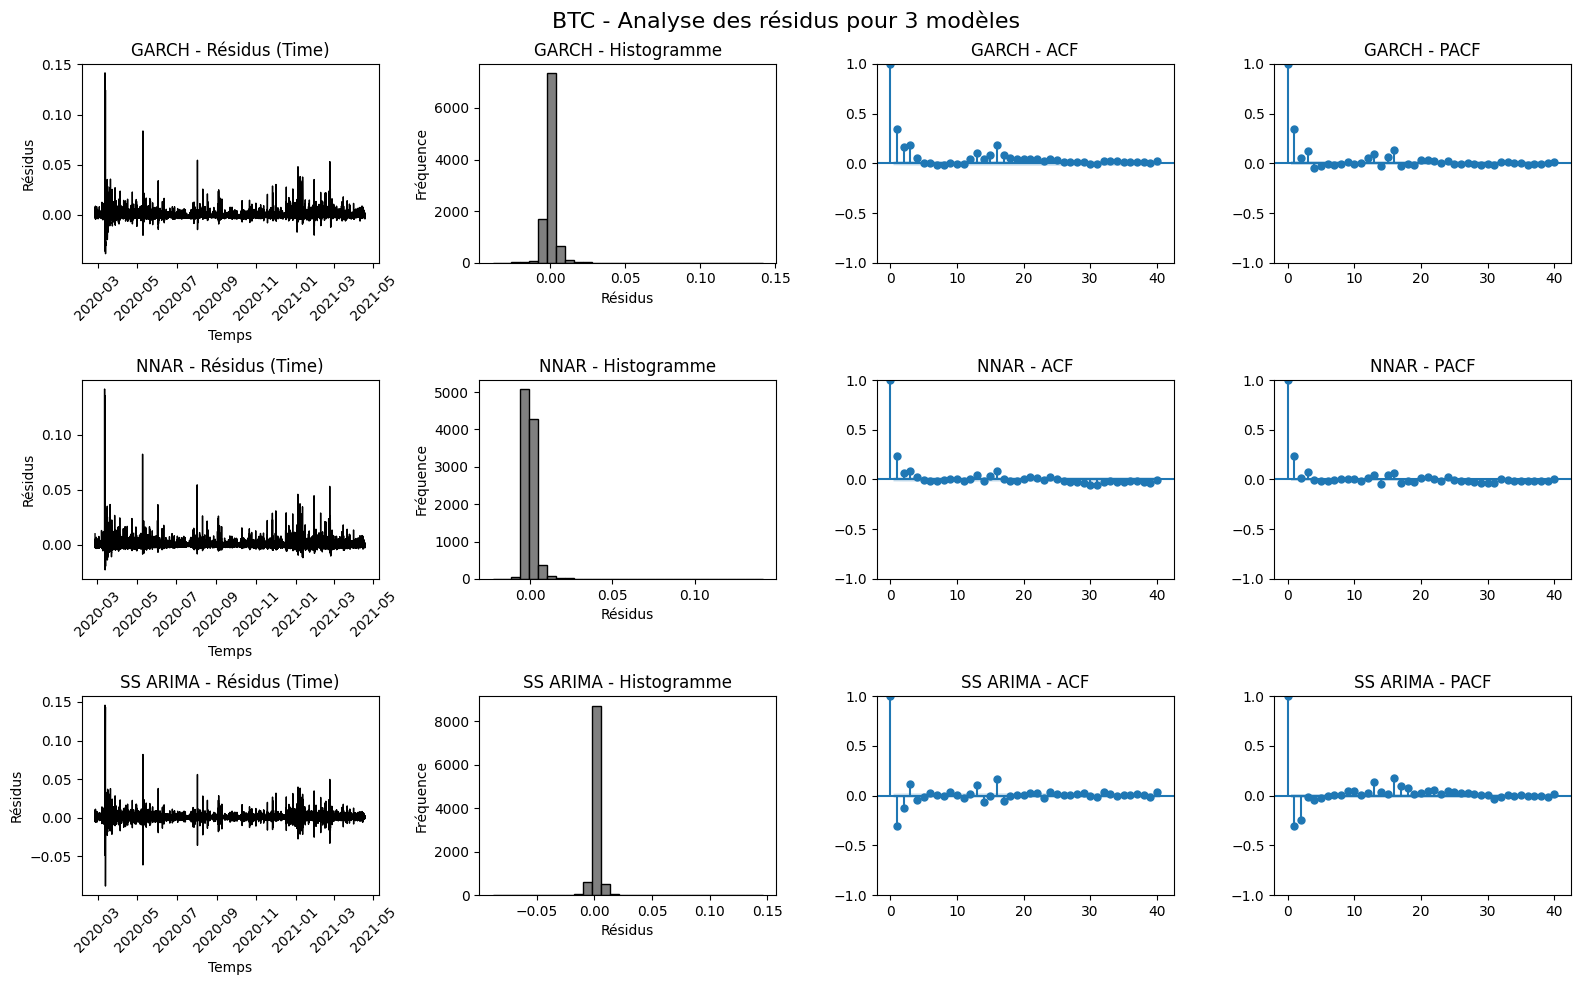

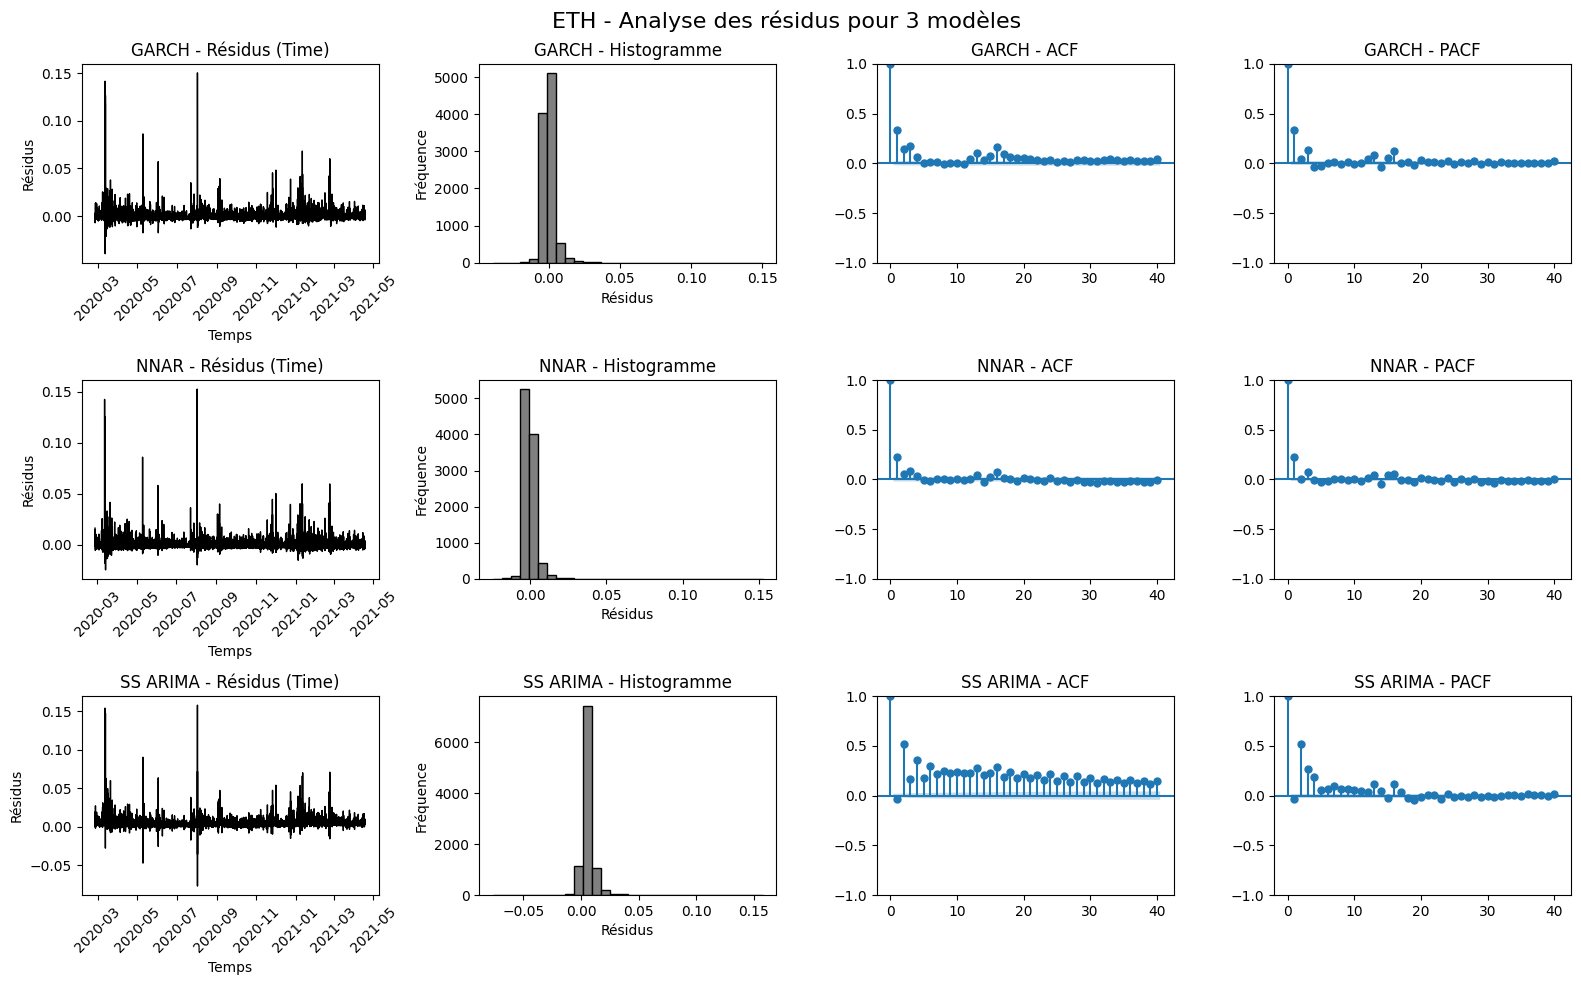

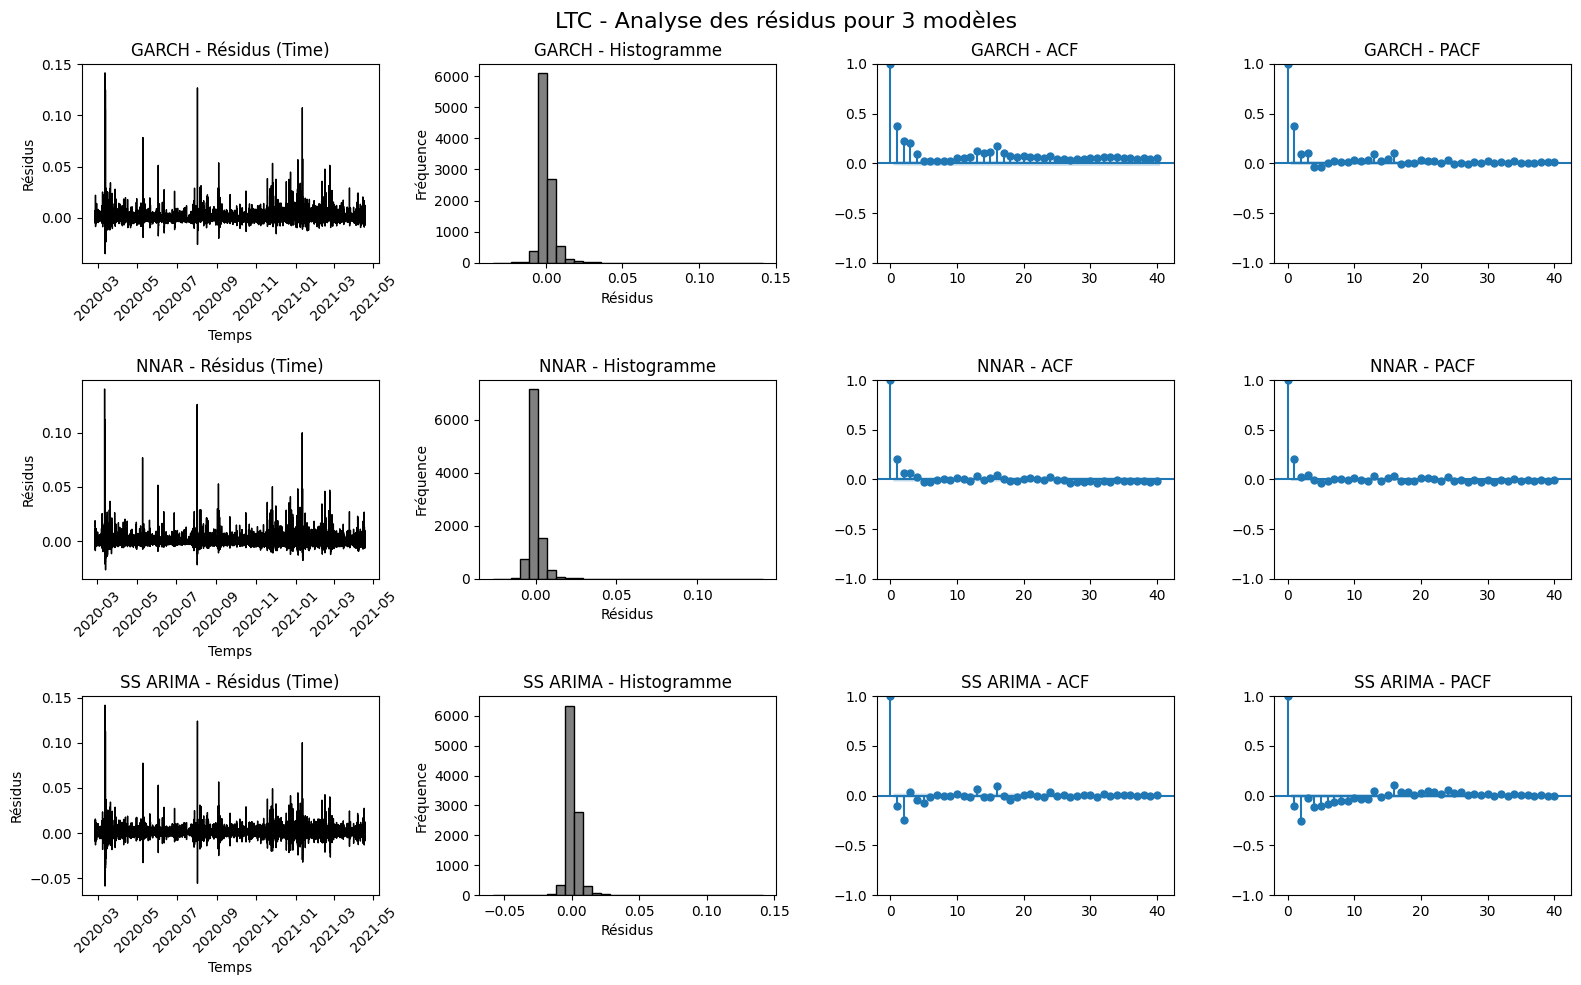

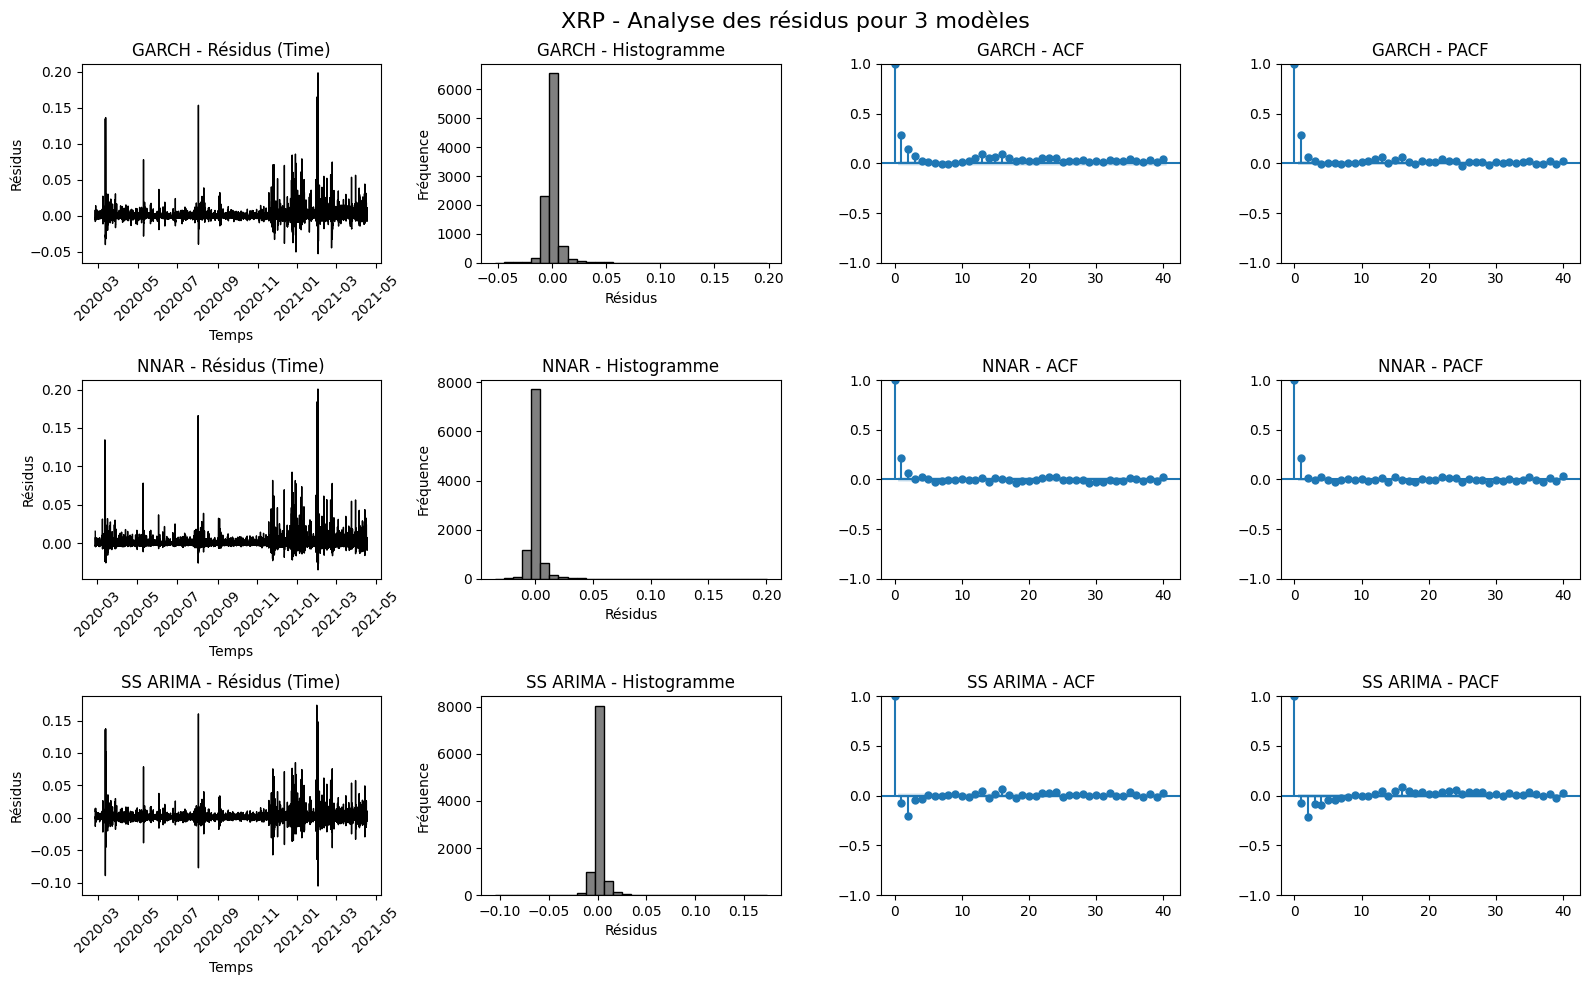

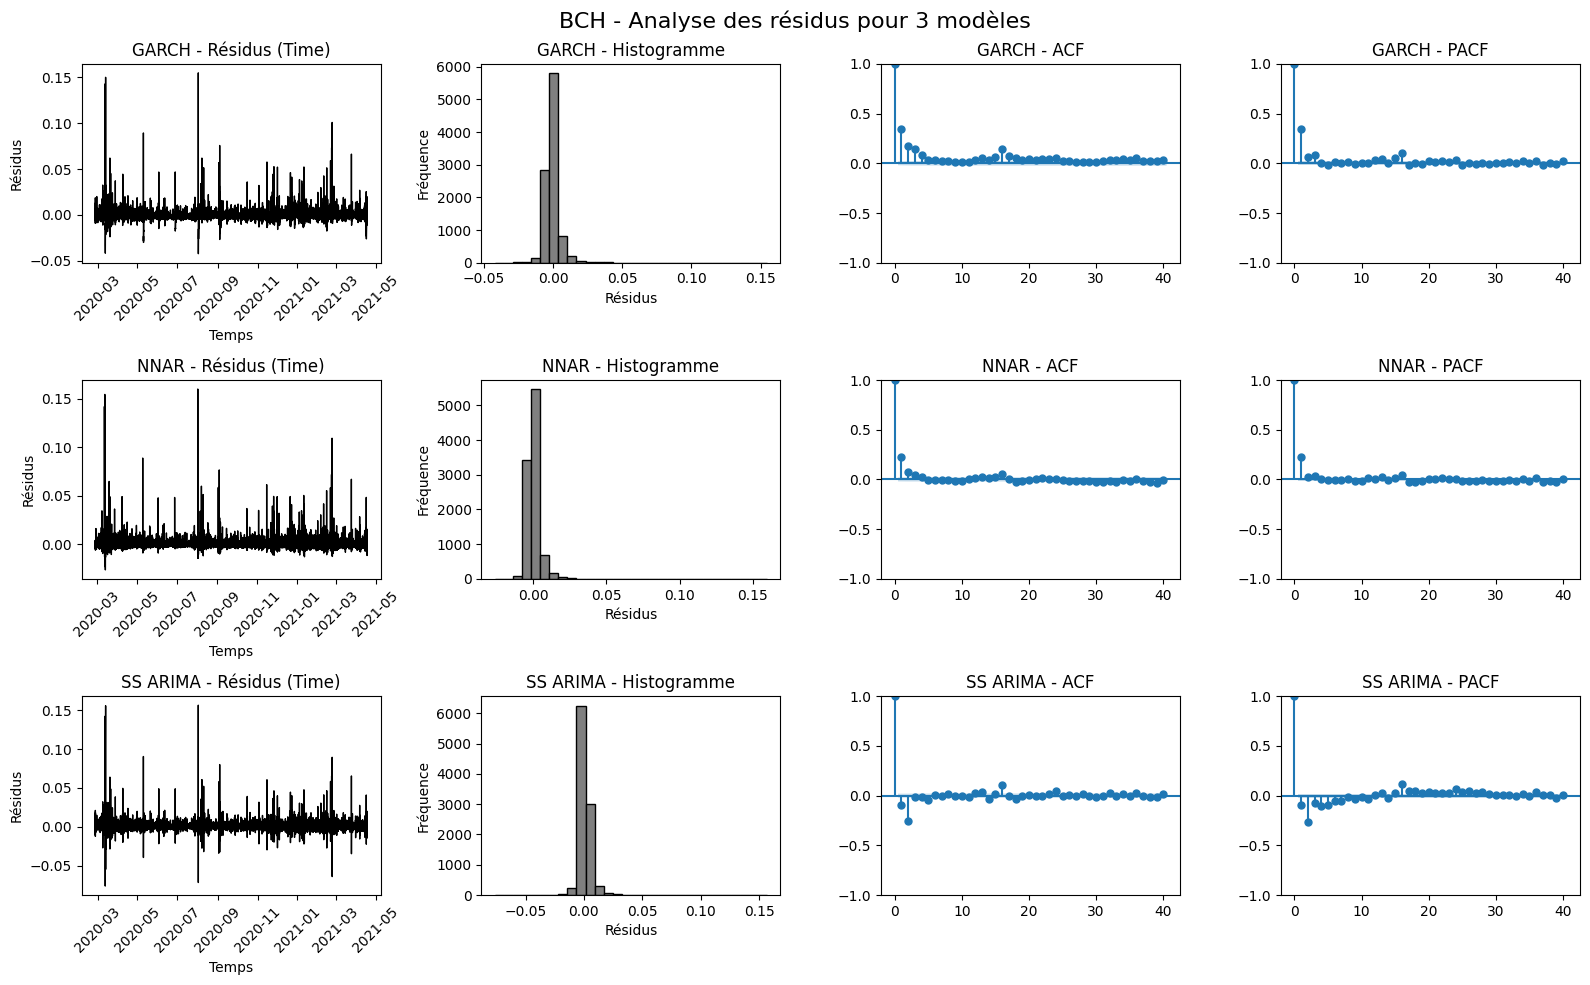

In [24]:
models_order = ["GARCH", "NNAR", "SS ARIMA"]  # L'ordre que je veux représenter

residuals_1_min = {crypto: {"GARCH": None, "NNAR": None, "SS ARIMA": None} for crypto in results_1_min}

for name in results_1_min:
    for model in residuals_1_min[name]:
        residuals_1_min[name][model] = results_1_min[name][model]['Residuals']
        
for crypto in residuals_1_min:

    # Crée une figure 3x4 : 3 lignes (pour 3 modèles), 4 colonnes (time series, hist, ACF, PACF)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
    fig.suptitle(f"{crypto} - Analyse des résidus pour 3 modèles", fontsize=16)
    for i, model in enumerate(models_order):

        res = residuals_1_min[crypto][model]

        if hasattr(res, "dropna"):
            res = res.dropna()
        else:
            res = res[~np.isnan(res)]

        # 1) Plot Time Series
        axes[i, 0].plot(res, color='black', linewidth=1)
        axes[i, 0].set_title(f"{model} - Résidus (Time)")
        axes[i, 0].set_xlabel("Temps")
        axes[i, 0].set_ylabel("Résidus")
        
        # Configuration des ticks de l'axe des x
        axes[i, 0].xaxis.set_major_locator(mdates.AutoDateLocator()) 
        axes[i, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  
        axes[i, 0].tick_params(axis='x', rotation=45)  

        # Histogram
        axes[i, 1].hist(res, bins=30, color='gray', edgecolor='black')
        axes[i, 1].set_title(f"{model} - Histogramme")
        axes[i, 1].set_xlabel("Résidus")
        axes[i, 1].set_ylabel("Fréquence")

        # ACF
        plot_acf(res, ax=axes[i, 2], lags=40, alpha=0.05)
        axes[i, 2].set_title(f"{model} - ACF")
        # PACF
        plot_pacf(res, ax=axes[i, 3], lags=40, alpha=0.05, method='ywm')
        axes[i, 3].set_title(f"{model} - PACF")

    plt.tight_layout()
    plt.show()

## REPRESENTATION GRAPHIQUE VOL IC 

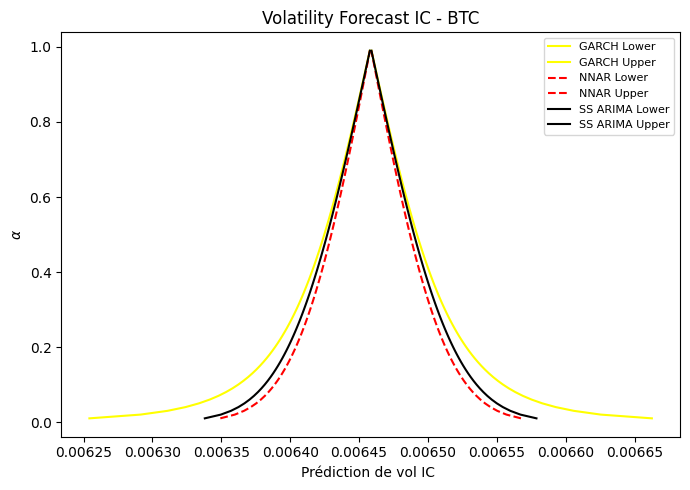

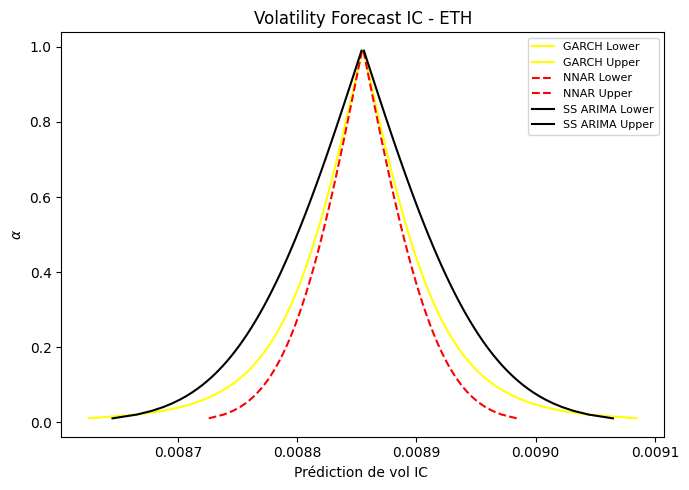

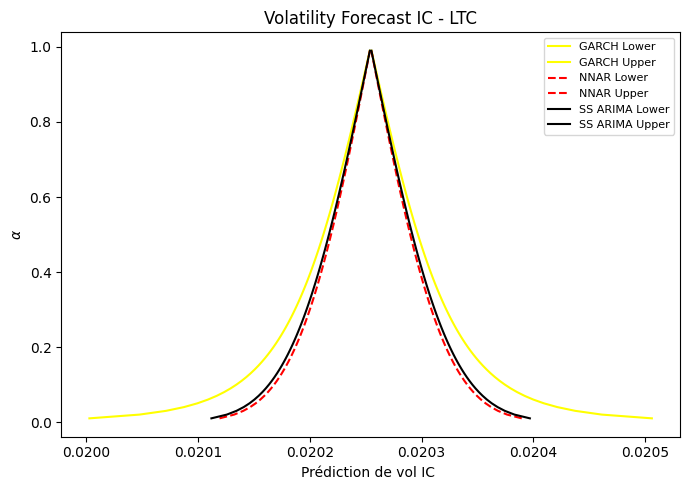

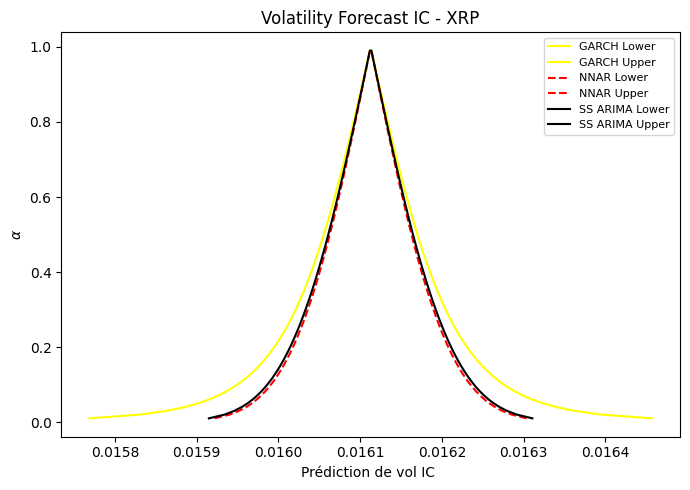

In [25]:
alpha_array = np.arange(0.01, 1.00, 0.01)

all_vol_ci_1_min = {}
for name in results_1_min:
    vol_ci_1_min = compute_volatility_ci(results_1_min[name], alpha_array)
    plot_IC(vol_ci_1_min, title=f"Volatility Forecast IC - {name}")
    all_vol_ci_1_min[name] = vol_ci_1_min

## REPRESENTATION GRAPHIQUE VaR IC 

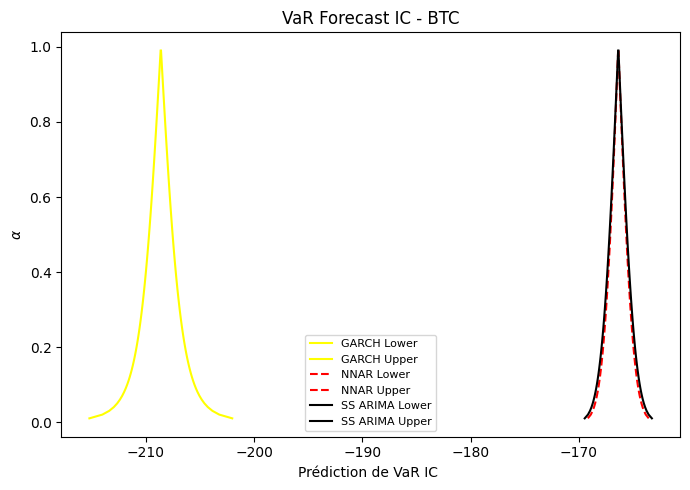

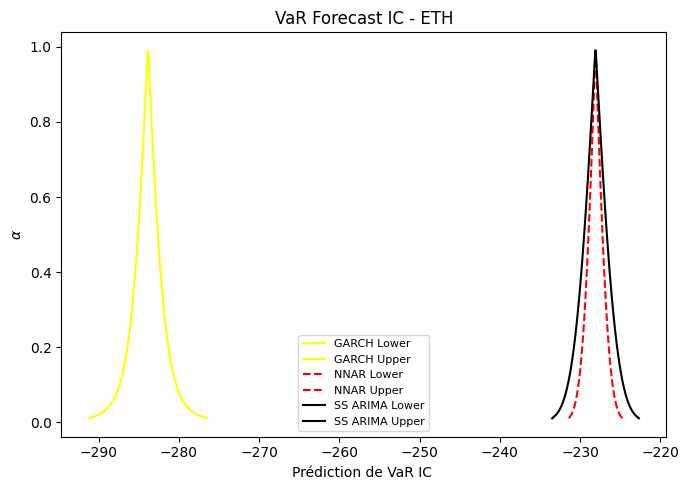

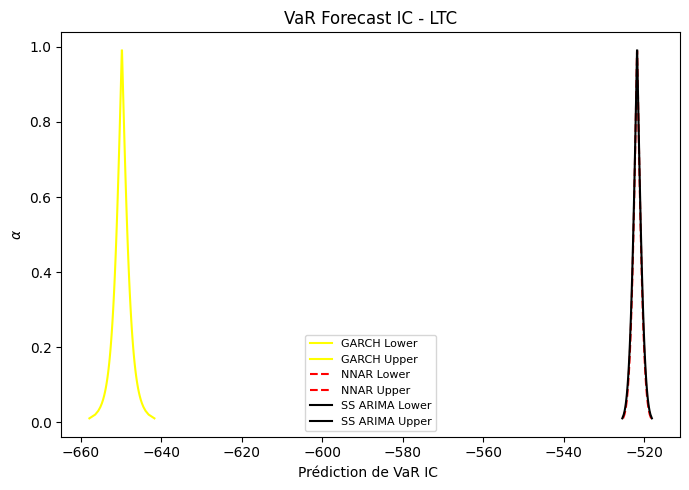

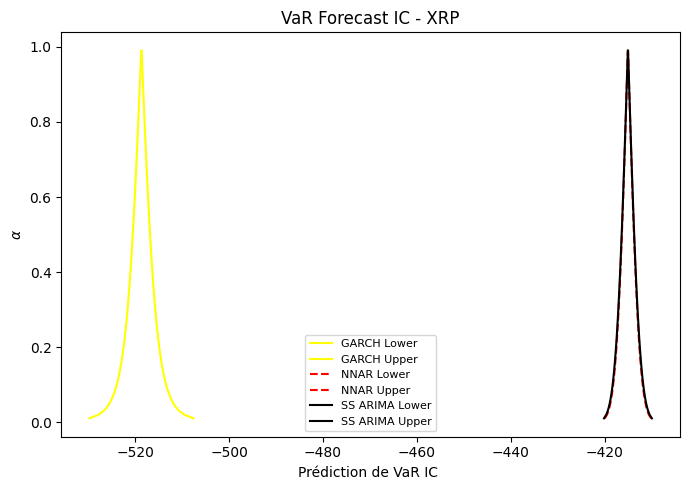

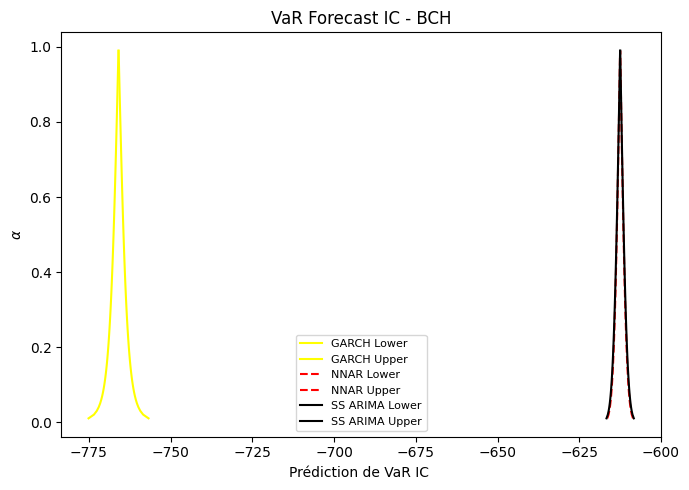

In [26]:
#Version correcte
for name in results_1_min: 
    vol_ci_1_min = all_vol_ci_1_min[name]
    
    var_ci_1_min = compute_var_ci(vol_ci_1_min, alpha_array, results_1_min[name], alpha_var=0.01, nominal=10_000)
    plot_IC(var_ci_1_min, title=f"VaR Forecast IC - {name}", type="VaR")

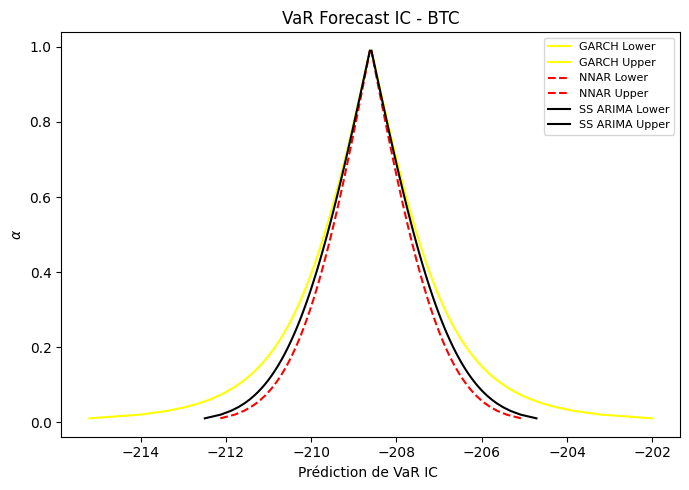

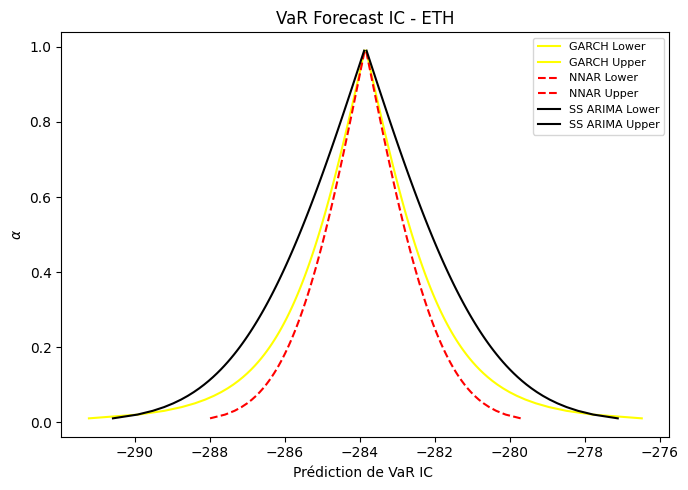

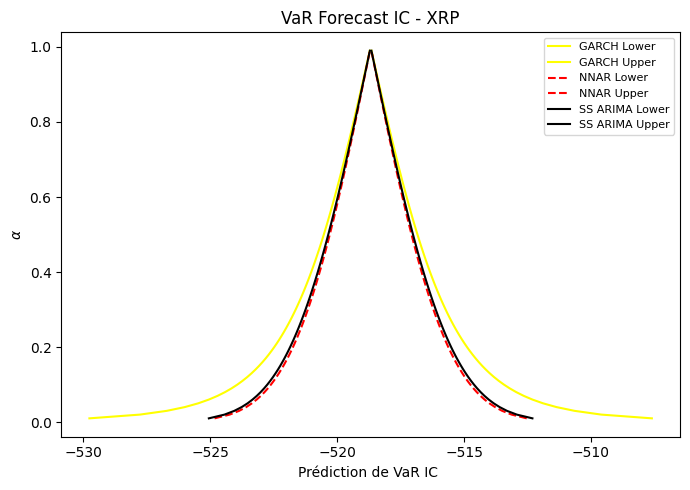

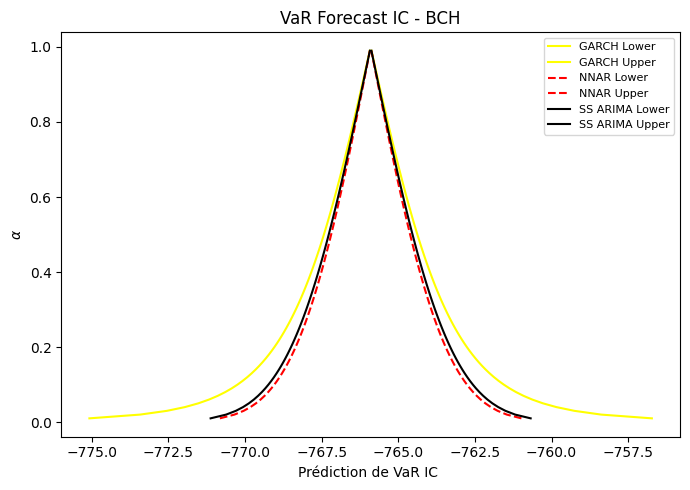

In [27]:
#Version correcte
for name in results_1_min: 
    vol_ci_1_min = all_vol_ci_1_min[name]
    
    var_ci_1_min = compute_var_ci_df(vol_ci_1_min, alpha_array, results_1_min[name], alpha_var=0.01, nominal=10_000)
    plot_IC(var_ci_1_min, title=f"VaR Forecast IC - {name}", type="VaR")

## Extension de modèle 